In [1]:
import matplotlib
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None

In [2]:
def parse_data(given_path, file_name):
   metars_path = os.path.join(given_path, file_name)
   metars_data = pd.read_csv(metars_path)
   return metars_data

In [5]:
save_path = os.path.abspath(os.path.join(os.pardir, 'data'))
given_data_1 = parse_data(save_path, 'metars_cache_1.csv')
given_data_2 = parse_data(save_path, 'metars_test_cache.csv')
given_data_3 = parse_data(save_path, 'metars_test2_cache.csv')
 
# Concatenate all of these DataFrames
given_data = pd.concat([given_data_1, given_data_2, given_data_3])
 
display(given_data)

,raw_text,station_id,observation_time,latitude,longitude,temp_c,dewpoint_c,wind_dir_degrees,wind_speed_kt,wind_gust_kt,...,maxT24hr_c,minT24hr_c,precip_in,pcp3hr_in,pcp6hr_in,pcp24hr_in,snow_in,vert_vis_ft,metar_type,elevation_m
0,KBCT 220253Z 35007KT 10SM VCTS BKN050 22/17 A3...,KBCT,2022-10-22T02:53:00Z,26.38,-80.10,22.0,17.0,350.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,3.0
1,YSNF 220252Z AUTO 09007KT 9999 -SHRA SCT020 SC...,YSNF,2022-10-22T02:52:00Z,-29.03,167.93,18.0,16.0,90.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPECI,113.0
2,YCOM 220252Z AUTO 01013KT 5000 // SCT013 SCT02...,YCOM,2022-10-22T02:52:00Z,-36.30,148.97,NaN,NaN,10.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPECI,930.0
3,PAFM 220252Z AUTO 12003KT 10SM FEW004 SCT015 O...,PAFM,2022-10-22T02:52:00Z,67.10,-157.85,1.0,0.0,120.0,3.0,NaN,...,NaN,NaN,0.005,NaN,NaN,NaN,NaN,NaN,SPECI,79.0
4,PABV 220252Z AUTO 05003KT 10SM BKN004 02/02 A2...,PABV,2022-10-22T02:52:00Z,61.42,-149.52,2.0,2.0,50.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPECI,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4767,MMGM 222340Z 20008KT 10SM SCT030 BKN120 29/26 ...,MMGM,2022-10-22T23:40:00Z,27.95,-110.92,29.0,26.0,200.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,13.0
4768,MMCV 222340Z 16009KT 10SM BKN250 26/15 A2988 R...,MMCV,2022-10-22T23:40:00Z,23.72,-98.97,26.0,15.0,160.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,230.0
4769,MMCN 222340Z 24005KT 10SM BKN210 29/20 A2973 R...,MMCN,2022-10-22T23:40:00Z,27.40,-109.83,29.0,20.0,240.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,57.0
4770,MMCB 222340Z 00000KT 9SM SCT015 BKN080 BKN250 ...,MMCB,2022-10-22T23:40:00Z,18.83,-99.27,25.0,19.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,1281.0


In [6]:
# Do some basic cleaning to get rid of rows that are missing lat/long, since that's the bare minimum we need
cleaned_data = given_data.dropna(axis=0, subset=['latitude', 'longitude'])
cleaned_data = cleaned_data.reset_index(drop=True)

In [61]:
def filter_usa(df: pd.DataFrame) -> pd.DataFrame:
   """Takes in world data and crudely restricts to just lat/long values corresponding to the lower 48"""
 
   # We'll be using latitude bounds of [24, 49] and longitude bounds of [-125, -67] based on https://www.findlatitudeandlongitude.com/l/Lower+48/4315442/
   return df.loc[(df['latitude'] >= 24) & (df['latitude'] <= 49) & (df['longitude'] >= -125) & (df['longitude'] <= -67)]
    
# Get a rough estimate of the data corresponding to the US (minus Alaska and Hawaii)
usa_data = filter_usa(cleaned_data)
 
# Also, because 'Murica, let's change the units from C to F
usa_data['temp_f'] = usa_data['temp_c'].apply(lambda x: (x * (9.0 / 5.0) + 32))
usa_data['dewpoint_f'] = usa_data['dewpoint_c'].apply(lambda x: (x * (9.0 / 5.0) + 32))

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
cleaned_usa = usa_data.dropna(axis=0, subset=['temp_c', 'dewpoint_c', 'wind_speed_kt', 'visibility_statute_mi'])
cleaned_usa = cleaned_usa.reset_index(drop=True)
 
print("Number of Rows: ", len(cleaned_usa.index))
speci_data = cleaned_usa.loc[cleaned_usa['metar_type'] == 'SPECI']
print("Number of SPECI Rows: ", len(speci_data.index))
 
metar_data = cleaned_usa.loc[cleaned_usa['metar_type'] == 'METAR']
print("Number of METAR Rows: ", len(metar_data.index))
downsized_metar_data = metar_data.sample(n=len(speci_data.index))
 
# Put together the SPECI data and sampled METAR data
combined_data = pd.concat([speci_data, downsized_metar_data])
print("Size of Re-Balanced/Sampled Dataset: ", len(combined_data.index))

inputs = combined_data.loc[:, ['temp_c', 'dewpoint_c', 'wind_speed_kt', 'visibility_statute_mi']]
# Scale the inputs metrics
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(inputs)
scaled_inputs = pd.DataFrame(data=scaled_arr, columns=inputs.columns)
 
outputs = combined_data.loc[:, 'metar_type']
 
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(scaled_inputs, outputs, test_size=0.2)


Number of Rows:  6589
Number of SPECI Rows:  633
Number of METAR Rows:  5956
Size of Re-Balanced/Sampled Dataset:  1266


In [80]:
from sklearn.linear_model import LogisticRegression
 
logModel = LogisticRegression(penalty='l1', solver='saga')
 
logModel.fit(inputs_train, outputs_train)
 
pred_output = logModel.predict(inputs_test)
 
print("Accuracy:", accuracy_score(outputs_test, pred_output))
 
speci_counter = 0
for x in range(len(pred_output)):
   if pred_output[x] == 'SPECI':
       speci_counter += 1
 
print(speci_counter)

Accuracy: 0.5826771653543307
112


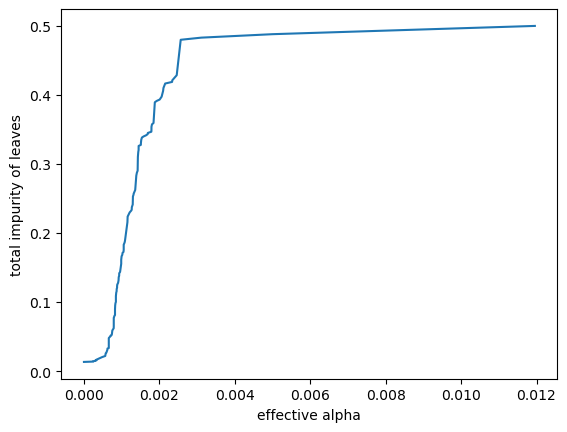

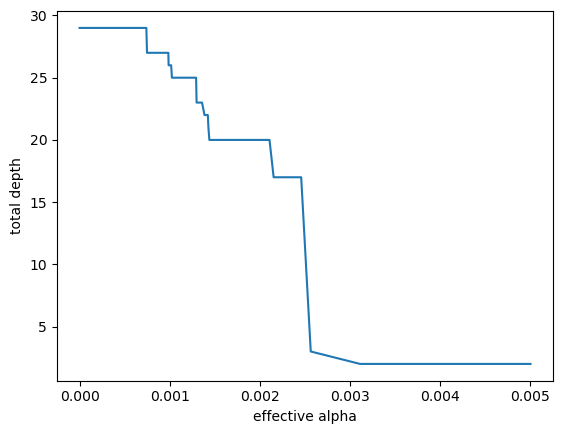

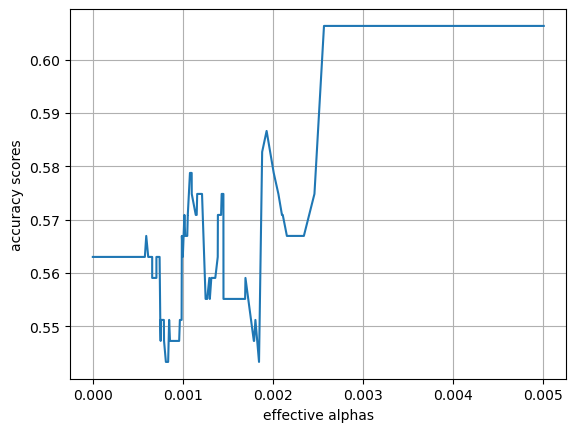

In [81]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(inputs_train, outputs_train)

path = clf.cost_complexity_pruning_path(inputs_train, outputs_train)
path

ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure()
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

clfs = []

for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(inputs_train, outputs_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

from sklearn.metrics import accuracy_score

acc_scores = [accuracy_score(outputs_test, clf.predict(inputs_test)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure()
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alphas")
plt.ylabel("accuracy scores")

pred_output_tree = clf.predict(inputs_test)



#tree.plot_tree(clf)

In [82]:
from sklearn import svm

clf = svm.SVC(kernel='rbf') #linear kernel
clf.fit(inputs_train, outputs_train)
outputs_pred = clf.predict(inputs_test)

from sklearn import metrics
print("Accuracy: ", metrics.accuracy_score(outputs_test, outputs_pred))


Accuracy:  0.5984251968503937
